### Sequential neural posterior estimation
Sequential neural posterior estimation (SNPE) is an algorithm for fitting posterior
distributions to intractable simulator models. SNPE uses multiple rounds of simulations,
in which posterior estimates from each round are used as proposal distributions for the
subsequent round. This can lead to much higher simulation efficiency compared to a
single round approach. The variant of SNPE used here is often referred to as SNPE-C,
as described by [Greenberg et al. (2019)](https://arxiv.org/abs/1905.07488) and
[Durkan et al. (2020)](https://arxiv.org/abs/2002.03712).

In [8]:
import equinox as eqx
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from jax import vmap

import flowjax.bijections as bij
from flowjax.distributions import Normal, Transformed
from flowjax.flows import masked_autoregressive_flow
from flowjax.tasks import GaussianMixtureSimulator
from flowjax.train.data_fit import fit_to_data
from flowjax.train.losses import ContrastiveLoss, MaximumLikelihoodLoss

The task we consider is to infer the mean of a mixture of two two-dimensional Normal distributions, in which one of the distributions has a much broader variance.
$$\theta_i \sim \text{Uniform}(-10,\ 10),\quad i=1,2$$
$$x | \theta \sim 0.5 \cdot N(\theta,\ I_2) + 0.5 \cdot N(\theta,\ 0.1^2 \odot I_2)$$

In [9]:
task = GaussianMixtureSimulator()

# Generating an "observation"
key, subkey = jr.split(jr.PRNGKey(0))
theta_true = task.prior.sample(subkey)
key, subkey = jr.split(key)
observed = task.simulator(subkey, theta_true)

We use an affine masked autoregressive flow as our proposal/posterior estimator

In [10]:
key, subkey = jr.split(key)
proposal = masked_autoregressive_flow(
    subkey,
    base_dist=Normal(jnp.zeros(2)),
    transformer=bij.Affine(),
    cond_dim=observed.size,
)

As the task is defined on bounded support $[-10, 10]$, we define a map to the unbounded domain which often is more stable for training.

In [11]:
to_unbounded = bij.Chain(
    [
        bij.Affine(jnp.zeros(task.dim), 1 / task.prior_bound),  # to [-1, 1]
        bij.Invert(bij.Tanh((task.dim,))),  # Arctanh (to unbounded)
    ],
)

unbounded_prior = Transformed(task.prior, to_unbounded)

For SNPE, training using the standard maximum likelihood loss would lead to biased posterior estimates if used over multiple rounds of simulations. Instead, following the approach [here](https://arxiv.org/pdf/2002.03712.pdf), we use [MaximumLikelihoodLoss](../api/losses.rst#flowjax.train.losses.MaximumLikelihoodLoss) for the first round, followed by [ContrastiveLoss](../api/losses.rst#flowjax.train.losses.ContrastiveLoss) for any subsequent rounds. Here we carry out SNPE using 3 rounds of simulations.

In [12]:
sim_per_round = 1000

data = {"theta": [], "simulations": []}
losses = []
for r in range(3):
    # Carry out simulations (from prior for round 1, the running proposal otherwise).
    key, subkey = jr.split(key)
    if r == 0:
        theta_r = unbounded_prior.sample(subkey, (sim_per_round,))
        loss_fn = MaximumLikelihoodLoss()
    else:
        theta_r = eqx.filter_jit(proposal.sample)(
            subkey, (sim_per_round,), condition=observed,
        )
        loss_fn = ContrastiveLoss(unbounded_prior, n_contrastive=10)

    key, subkey = jr.split(key)
    simulations_r = task.simulator(
        key=subkey,
        theta=vmap(to_unbounded.inverse)(theta_r),  # Map to bounded for simulating
    )

    data["theta"].append(theta_r)
    data["simulations"].append(simulations_r)

    key, subkey = jr.split(key)
    proposal, losses_r = fit_to_data(
        key=subkey,
        dist=proposal,
        loss_fn=loss_fn,
        x=jnp.concatenate(data["theta"]),  # Note x is package convention for target!
        condition=jnp.concatenate(data["simulations"]),
        learning_rate=1e-4,
        max_epochs=200,
    )
    losses.append(losses_r)

  7%|▋         | 14/200 [00:05<01:06,  2.79it/s, train=-1.1592803, val=-1.2882015 (Max patience reached)]


We can map the posterior distribution, and the $\theta$ samples from each round back to the bounded domain

In [13]:
# Undo preprocessing (map everything back to bounded domain)
posterior = Transformed(proposal, bij.Invert(to_unbounded))
data["theta"] = [vmap(to_unbounded.inverse)(t) for t in data["theta"]]

# Append posterior samples
key, subkey = jr.split(key)
data["theta"].append(
    posterior.sample(
        subkey, (sim_per_round,), condition=observed,
    ),
)

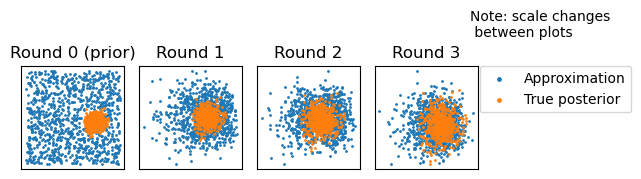

In [14]:
key, subkey = jr.split(key)
reference_posterior = task.sample_reference_posterior(subkey, observed, sim_per_round)

fig, axes = plt.subplots(ncols=len(data["theta"]))

for r, (ax, samps) in enumerate(zip(axes, data["theta"], strict=True)):
    ax.scatter(samps[:, 0], samps[:, 1], s=1, label="Approximation")
    ax.scatter(
        x=reference_posterior[:, 0],
        y=reference_posterior[:, 1],
        s=1,
        label="True posterior",
    )
    title = "Round 0 (prior)" if r == 0 else f"Round {r}"
    ax.set_title(title)
    ax.set_box_aspect(1)
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])

lgnd = plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
for handle in lgnd.legend_handles:
    handle.set_sizes([6.0])

plt.tight_layout()
plt.text(8, 6.5, "Note: scale changes \n between plots")
plt.show()